# Food Vision 🍔👁 Mini Project
**Objective**: This notebook aims to achieve better performance on the Food101 dataset compared to the 2016 paper [Deep Food](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment), which utilized Convolutional Neural Networks (CNNs) and achieved a 77.4% accuracy on the test dataset.

**Dataset**: We will download the Food101 dataset from [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview), which contains 101 classes of various foods. This diverse dataset is well-suited for food image recognition tasks.

**Approach**: To accomplish this, we will employ transfer learning techniques, leveraging state-of-the-art base models. These models will be fine-tuned on the Food101 dataset. We will also make use of Mixed Precision Training to expedite the training process. Note that for Mixed Precision Training to be effective, you will need a GPU with a compute capability score of 7.0 or higher. You can check your GPU's score [here](https://developer.nvidia.com/cuda-gpus#compute).

**Mixed Precision Training**: Mixed precision learning leverages the use of GPUs and combines single precision (float32) and half-precision (float16) data types to accelerate model training. For more information on Mixed Precision Training, you can refer to the [TensorFlow documentation](https://www.tensorflow.org/guide/mixed_precision).

**Note**: Make sure to set up your runtime environment to utilize GPUs for faster training and inference.

Let's get started with the project!





In [15]:
# Get helper functions file, that contains different functions usefull for analaysing data and evaluating models.
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [16]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves

In [17]:
import matplotlib.pyplot as plt

def plot_loss_curves(history, metrics=['accuracy'], finetune=False):
    """
    Plot loss and specified metrics for a TensorFlow model History object or a list of History objects.

    Args:
      history: TensorFlow model History object or a list of History objects. When finetune is True, provide at least two history objects.
      metrics: List of metrics to plot (default is ['accuracy']).
      finetune: Boolean indicating whether the histories are connected (default is False).

    Returns:
      None
    """
    # Check for valid input when finetune is True
    if finetune and len(history) < 2:
        raise ValueError("When 'finetune' is True, provide at least two history objects.")

    # Convert a single history object to a list
    if not isinstance(history, (list, tuple)):
        history = [history]

    # Determine the total number of epochs for all histories
    total_epochs = sum([len(hist.history['loss']) for hist in history])

    if finetune:
        # Combine histories
        combined_history = {
            'loss': [],
            'val_loss': [],
        }

        for metric in metrics:
            combined_history[metric] = []
            combined_history['val_' + metric] = []

        for idx, hist in enumerate(history):
            initial_epochs = sum([len(h.history['loss']) for h in history[:idx]])
            combined_history['loss'] += hist.history['loss']
            combined_history['val_loss'] += hist.history['val_loss']

            for metric in metrics:
                combined_history[metric] += hist.history[metric]
                combined_history['val_' + metric] += hist.history['val_' + metric]

        # Create a single subplot for combined history
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Initialize the epoch counter
        epochs = range(1, total_epochs + 1)

        # Plot combined loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, combined_history['loss'], label='Training Loss')
        plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')
        plt.axvline(x=initial_epochs, color='gray', linestyle='--')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot specified metrics for combined history
        plt.subplot(1, 2, 2)
        for metric in metrics:
            if metric in combined_history:
                plt.plot(epochs, combined_history[metric], label=f'Training {metric}')
                plt.plot(epochs, combined_history['val_' + metric], label=f'Validation {metric}')
        plt.axvline(x=initial_epochs, color='gray', linestyle='--')
        plt.title('Metrics')
        plt.xlabel('Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

    else:
        # Original logic for plotting individual histories
        num_histories = len(history)
        if num_histories == 1:
            # Add a single subplot for one history
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        else:
            fig, axs = plt.subplots(num_histories, 2, figsize=(12, 6*num_histories))

        # Initialize the epoch counter
        epoch_counter = 0

        for idx, hist in enumerate(history):
            # Update the epoch counter
            epochs = range(epoch_counter, epoch_counter + len(hist.history['loss']))
            epoch_counter += len(hist.history['loss'])

            # When finetune is False, use the appropriate subplot for each history
            if num_histories == 1:
                axs[0].plot(epochs, hist.history['loss'], label=f'Training Loss (Run {idx+1})')
                axs[0].plot(epochs, hist.history['val_loss'], label=f'Validation Loss (Run {idx+1})')
                axs[0].set_title(f'Loss')
                axs[0].set_xlabel('Epochs')
                axs[0].legend()

                # Plot specified metrics for each history
                for metric in metrics:
                    if metric in hist.history:
                        axs[1].plot(epochs, hist.history[metric], label=f'Training {metric} (Run {idx+1})')
                        axs[1].plot(epochs, hist.history["val_"+metric], label=f'Validation {metric} (Run {idx+1})')
                        axs[1].set_title(metric)
                        axs[1].set_xlabel('Epochs')
                        axs[1].legend()
            else:
                axs[idx, 0].plot(epochs, hist.history['loss'], label=f'Training Loss (Run {idx+1})')
                axs[idx, 0].plot(epochs, hist.history['val_loss'], label=f'Validation Loss (Run {idx+1})')
                axs[idx, 0].set_title(f'Loss')
                axs[idx, 0].set_xlabel('Epochs')
                axs[idx, 0].legend()

                # Plot specified metrics for each history
                for metric in metrics:
                    if metric in hist.history:
                        axs[idx, 1].plot(epochs, hist.history[metric], label=f'Training {metric} (Run {idx+1})')
                        axs[idx, 1].plot(epochs, hist.history["val_"+metric], label=f'Validation {metric} (Run {idx+1})')
                        axs[idx, 1].set_title(metric)
                        axs[idx, 1].set_xlabel('Epochs')
                        axs[idx, 1].legend()

        plt.tight_layout()
        plt.show()

In [4]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-aed34136-80a3-e7b8-7126-d6b84e284602)


In [5]:
# Check TF version, Mixed Precision training is available from 2.4.0
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.14.0


## Downloading the data

As mentioned previously we will download the data from TensorFlow Datasets which is a place for prepared and ready to use most popular ML datasets (benchmarks).



In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

KeyboardInterrupt: ignored

## Data analysis (Getting one with the data)

In order to build the models and evaluate them, we have to get to know the data which we are working with in depth.

Some of the questions we have to answer before we proceed are:

*   In what format our data is in?
*   What is the size of the images?
*   How does the images look, what classes are there, are there any similarity between different classes which will lead to hard predictions for our models? 🔑 **Visualize, visualize, visualize**

In [ ]:
# Features of Food101 stored as metadata
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 8
  Class name (str form): bread_pudding
        


In [ ]:
# Check to see if the data is already scaled
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

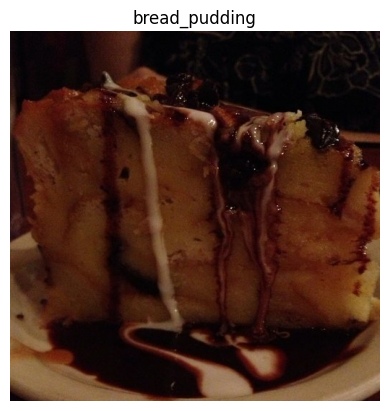

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## Data Preprocessing

There are few preprocessing steps that have to be done on the data in order to make it ready for the modeling.

That is, from the data analysis we saw that the data:

*   Is in `uint8` data type and has to be converted to `float` type.
*   Image tensors have different shapes, that is the images are different sizes, so they have to be resized in order to be batched
* Is not scaled (pixel values between 0-255), for better performance the values have to be scaled (normalized)

Therefore the function that resizes the images as well as converts it to `float`, and optionaly normalize it. This is optinal because some of the base models such as **EfficientNetBX** have the normalizing preprocessing layer built in, therefore to use that model images dont have to be normalized.




In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224, scale=False):
    """
    Converts image datatype from 'uint8' -> 'float32', reshapes image to
    [img_shape, img_shape, color_channels], and normalize it (optional)
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    if scale:
      image = image/255.
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[18  6  8]
  [18  6  8]
  [18  6  8]
  ...
  [30 15 22]
  [29 14 21]
  [26 11 18]]

 [[22 10 12]
  [21  9 11]
  [20  8 10]
  ...
  [35 20 27]
  [31 16 23]
  [26 11 18]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[20.158163   8.158163  10.158163 ]
  [18.42347    7.6173472  9.020408 ]
  [15.010203   6.423469   9.285714 ]
  ...
  [26.285824  15.714351  23.07156  ]
  [31.091867  17.285728  24.285728 ]
  [28.754953  13.754952  20.754953 ]]

 [[18.92857    8.928571   9.928571 ]
  [16.214285   7.0765305  8.07653  ]
  [14.739796   8.571429  10.627552 ]
  ...
  [26.444029  15.872557  21.658293 ]
  [39.86226   26.862259  33.86226  ]
  [39.49479   24.494787  31.494787 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


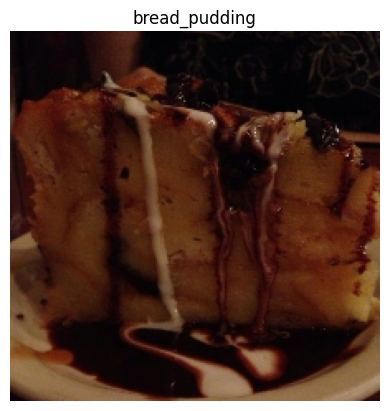

In [ ]:
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

### Batch and prepare datasets

To make computing more efficient, the data will be loaded into batches. To further optimize our input pipeline, we will follow the guidelines from the [tf.data API](https://www.tensorflow.org/guide/data_performance#vectorizing_mapping). We will use the following methods:

1. Parallelize the preprocessing by setting `num_parallel_calls=tf.data.AUTOTUNE` for the `map()` function, which applies our predefined preprocessing function to the entire dataset.
2. Utilize the `batch()` function to group data into batches, allowing for more efficient computation.
3. Implement the `prefetch()` function to overlap data loading and model training, reducing idle time and improving overall performance.

These methods will help us create an efficient and optimized data pipeline for our deep learning model.



In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create model callbacks

To ensure efficient training and tracking model progress, we'll set up modeling callbacks. These include:

- `tf.keras.callbacks.TensorBoard()`: To log and inspect the model's training history.
- `tf.keras.callbacks.ModelCheckpoint()`: To save the model's progress at intervals for later use or fine-tuning.

These callbacks allow us to monitor and save the model's performance and facilitate easy model management.


In [ ]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0)

## Set up mixed precision training

Mixed precision training optimizes GPU memory usage by using both float32 and float16 data types. Float16 (half-precision) uses less memory, allowing for faster computation and up to a 3x speedup on modern GPUs (compute capability score 7.0+).

To enable mixed precision training, you can import `tensorflow.keras.mixed_precision` and set the global dtype policy to "mixed_float16". This simple step makes your model automatically utilize float16 where possible, enhancing training speed.

Now, let's turn on mixed precision training in TensorFlow.


In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

We're ready to build a feature extraction model with mixed precision enabled. Since our dataset is large, we'll start with a feature extraction model before fine-tuning.

Here's the process:

1. Use EfficientNetB0 from `tf.keras.applications` pre-trained on ImageNet as the base model.
2. Download it without the top layers using `include_top=False` to create custom output layers.
3. Freeze the base model layers to utilize pre-learned patterns from ImageNet.
4. Create a Functional model by combining input, base model, pooling, and output layers.
5. Compile the model using the Adam optimizer and sparse categorical crossentropy as the loss function (since our labels aren't one-hot encoded).

🔑 Note: Due to mixed precision training, our model requires a separate output layer with `dtype=float32` to ensure numerical stability in loss calculations. This is critical for handling mixed data types. See the TensorFlow mixed precision guide for more details.


In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

## Fit the feature extraction model

We'll train our top layers for three epochs, which should be sufficient for them to adapt to our food image data.

To expedite training, we'll validate on only 15% of the test data per epoch.



In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_feature_extract = model.fit(train_data,
                                    epochs=3,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs",
                                                                          "efficientnetb0_feature_extract"),
                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_feature_extract/20231107-150259
Epoch 1/3
2368/2368 [==============================] - 200s 74ms/step - loss: 1.7178 - accuracy: 0.5815 - val_loss: 1.1308 - val_accuracy: 0.7010
Epoch 2/3
2368/2368 [==============================] - 182s 75ms/step - loss: 1.2005 - accuracy: 0.6883 - val_loss: 1.0350 - val_accuracy: 0.7219
Epoch 3/3
2368/2368 [==============================] - 183s 76ms/step - loss: 1.0543 - accuracy: 0.7229 - val_loss: 0.9874 - val_accuracy: 0.7304


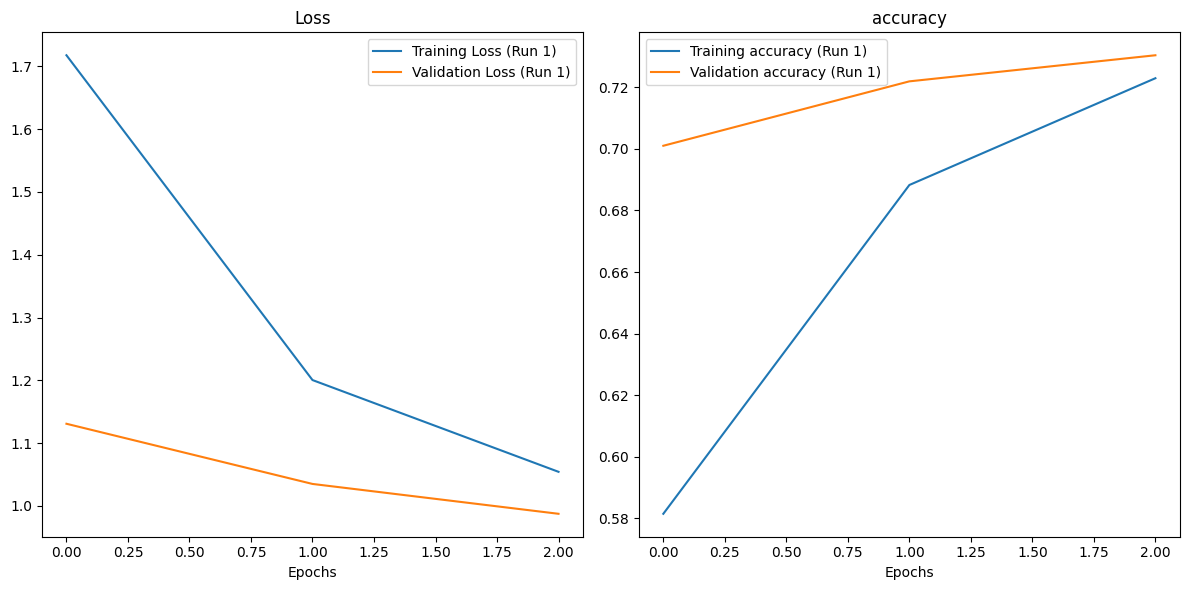

In [ ]:
plot_loss_curves(history_feature_extract)

In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 62s 79ms/step - loss: 1.0006 - accuracy: 0.7292


[1.0005748271942139, 0.7291881442070007]

## Load and Evaluate checkpoint weights

To load and evaluate checkpoint weights, follow these steps:

1. Recreate a new model instance, named `created_model`, using the original model creation code encapsulated in a function called `create_model()`.
2. Compile `created_model` with the same loss, optimizer, and metrics as the original model. (Remember to compile every new model you create.)
3. Use the `load_weights()` method on `created_model` to load checkpointed weights from the specified path.
4. Call `evaluate()` on `created_model` with the loaded weights and save the results.
5. Compare the results of `created_model` to those of the previous model. They should be nearly identical.

Checkpoints are valuable for experimenting, such as fine-tuning your model. If fine-tuning doesn't yield improvements, you can easily revert to the checkpointed model version.


In [ ]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# 2. Create and compile a new version of the original model (new weights)
fine_tune_model = create_model()
fine_tune_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
fine_tune_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = fine_tune_model.evaluate(test_data)

790/790 [==============================] - 56s 67ms/step - loss: 1.0006 - accuracy: 0.7292


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in fine_tune_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

## Preparing model's layers for fine-tuning

Our feature-extraction model has shown promise after three epochs, but we have a substantial amount of data. Fine-tuning becomes valuable when dealing with large datasets.

With a goal of surpassing the DeepFood paper's 77.4% accuracy, we consider fine-tuning.

In a traditional fine-tuning workflow, we freeze a pre-trained base model, train output layers, and then possibly unfreeze some base model layers for further training.

In [ ]:
# Set all layers to trainable
for layer in fine_tune_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Inspect base model's layers
for layer in fine_tune_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "mixed_float16">
normalization_1 True float32 <Policy "mixed_float16">
rescaling_3 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_f

It appears that all layers in our base model are trainable (unfrozen), and they are correctly utilizing the dtype policy "mixed_policy16."

Considering our substantial dataset (750 images per class across 101 training classes, totaling 75,750 training images), we'll proceed by keeping all the layers in our base model unfrozen.

🔑 Note: For smaller datasets (fewer than 100 images per class), it's advisable to unfreeze and fine-tune a limited number of layers in the base model to prevent overfitting.


## Create model callbacks for fine-tunning

Knowing when a deep learning model stops improving can be challenging. To address this, we can use the EarlyStopping callback.

The EarlyStopping callback monitors a chosen performance metric (e.g., val_loss) and automatically halts training when the metric doesn't improve for a specified number of epochs.

By combining EarlyStopping with the ModelCheckpoint callback (which saves the best-performing model automatically), we ensure our model trains until it no longer improves. We'll configure both to monitor our model's val_loss.


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 4 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=4)

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

Before we begin fine-tuning, there's one more callback to implement: `ReduceLROnPlateau`.

The learning rate is a crucial hyperparameter to tune, and the `ReduceLROnPlateau` callback assists in optimizing it.

This callback monitors a specified metric and, when that metric no longer improves, it reduces the learning rate by a specified factor (e.g., dividing it by 10).

🤔 Why lower the learning rate?

As the model approaches ideal performance (convergence), we reduce the learning rate to ensure smaller learning adjustments.

We'll use the `ReduceLROnPlateau` callback to monitor the validation loss, similar to `EarlyStopping`. When the validation loss doesn't improve for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g., from 0.001 to 0.0002).

To prevent the learning rate from becoming too small and stalling training, we'll set a minimum learning rate of 1e-7.


In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.1, # multiply the learning rate by 0.1 (reduce by 10x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

## Build fine-tunning model



In [ ]:
# Compile the model
fine_tune_model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.00005), # 15x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_fine_tune = fine_tune_model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_fine_tuning"), # track the model training logs
                                      model_checkpoint, # save only the best model during training
                                      early_stopping, # stop model after X epochs if no improvements
                                      reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_fine_tuning/20231107-151934
Epoch 1/100
2368/2368 [==============================] - 456s 171ms/step - loss: 0.8240 - accuracy: 0.7792 - val_loss: 0.7928 - val_accuracy: 0.7783 - lr: 5.0000e-05
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.8450
Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
2368/2368 [==============================] - 375s 157ms/step - loss: 0.5714 - accuracy: 0.8450 - val_loss: 0.7965 - val_accuracy: 0.7757 - lr: 5.0000e-05
Epoch 3/100
2368/2368 [==============================] - 406s 170ms/step - loss: 0.3183 - accuracy: 0.9197 - val_loss: 0.7725 - val_accuracy: 0.7977 - lr: 5.0000e-06
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.9298
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-07.
2368/2368 [==============================] - 400s 167ms/step - loss: 0.2805 -

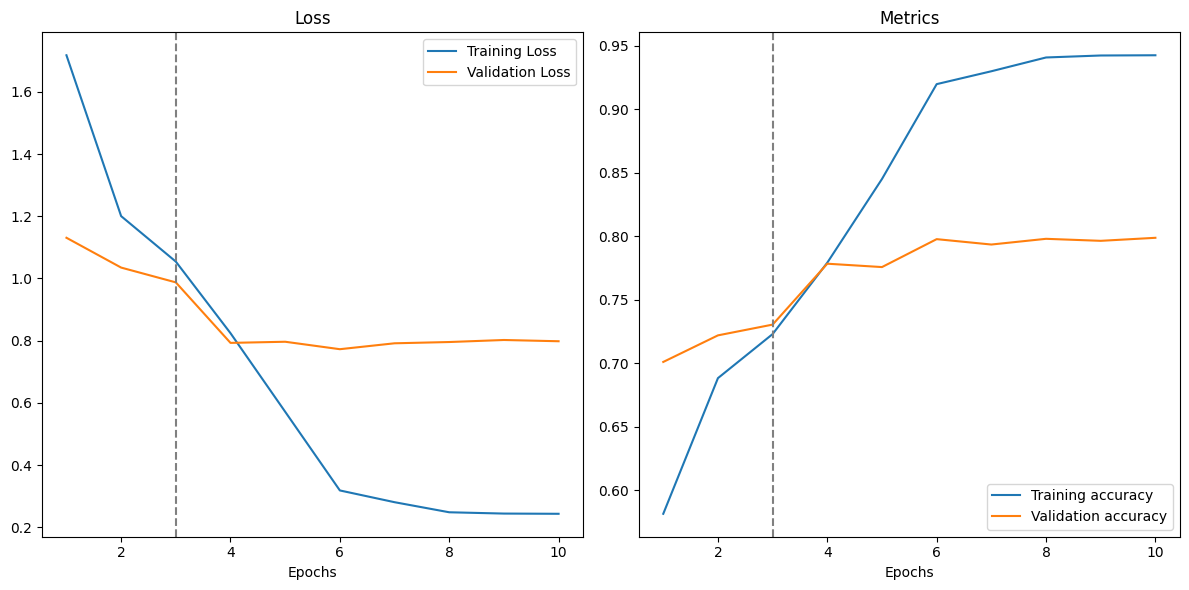

In [ ]:
history_list = [history_feature_extract, history_fine_tune]
metrics = ["accuracy", "accuracy"]


plot_loss_curves(history_list, finetune=True)

Seems like our fine tuned model is overfitting a lot. Let's evaluate it on whole data.

In [ ]:
# # Save model to Google Drive
fine_tune_model.save("/content/drive/MyDrive/FoodVisionFineTune/")

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
fine_tune_model.save("efficientnetb0_fine_tuned")

In [ ]:
results_fine_tune = fine_tune_model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 0.8066 - accuracy: 0.7947


## Model Evaluation

### Load saved fine tuned model

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
#saved_model_path = "efficientnetb0_fine_tuned.zip"
#unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
model = tf.keras.models.load_model("/content/drive/MyDrive/FoodVisionFineTune/") # path to drive model
#model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

In [ ]:
results_loaded = model.evaluate(test_data)

790/790 [==============================] - 66s 70ms/step - loss: 0.8066 - accuracy: 0.7947


###Making predictions with our trained model
To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the `predict()` method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata

In [ ]:
# Get class names
class_names = ds_info.features["label"].names

In [ ]:
# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
import numpy as np

# Assuming 'dataset' is your _PrefetchDataset
labels = []
for _, label in test_data:
    labels.extend(label.numpy())

# Convert list to numpy array
labels_array = np.array(labels)


In [ ]:
labels_array.shape

(25250,)

In [ ]:
# Then, make predictions on the entire test dataset
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 55s 68ms/step


In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:20], len(pred_classes), pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100,   4,  32,  32,
          3,   8,   8,  70,  60,  29,  80]),
 25250,
 (25250,))

In [ ]:
labels[:5]

[29, 81, 91, 53, 97]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
import sklearn
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(labels, pred_classes)
sklearn_accuracy

0.7946534653465347

### Plot confusion matrix


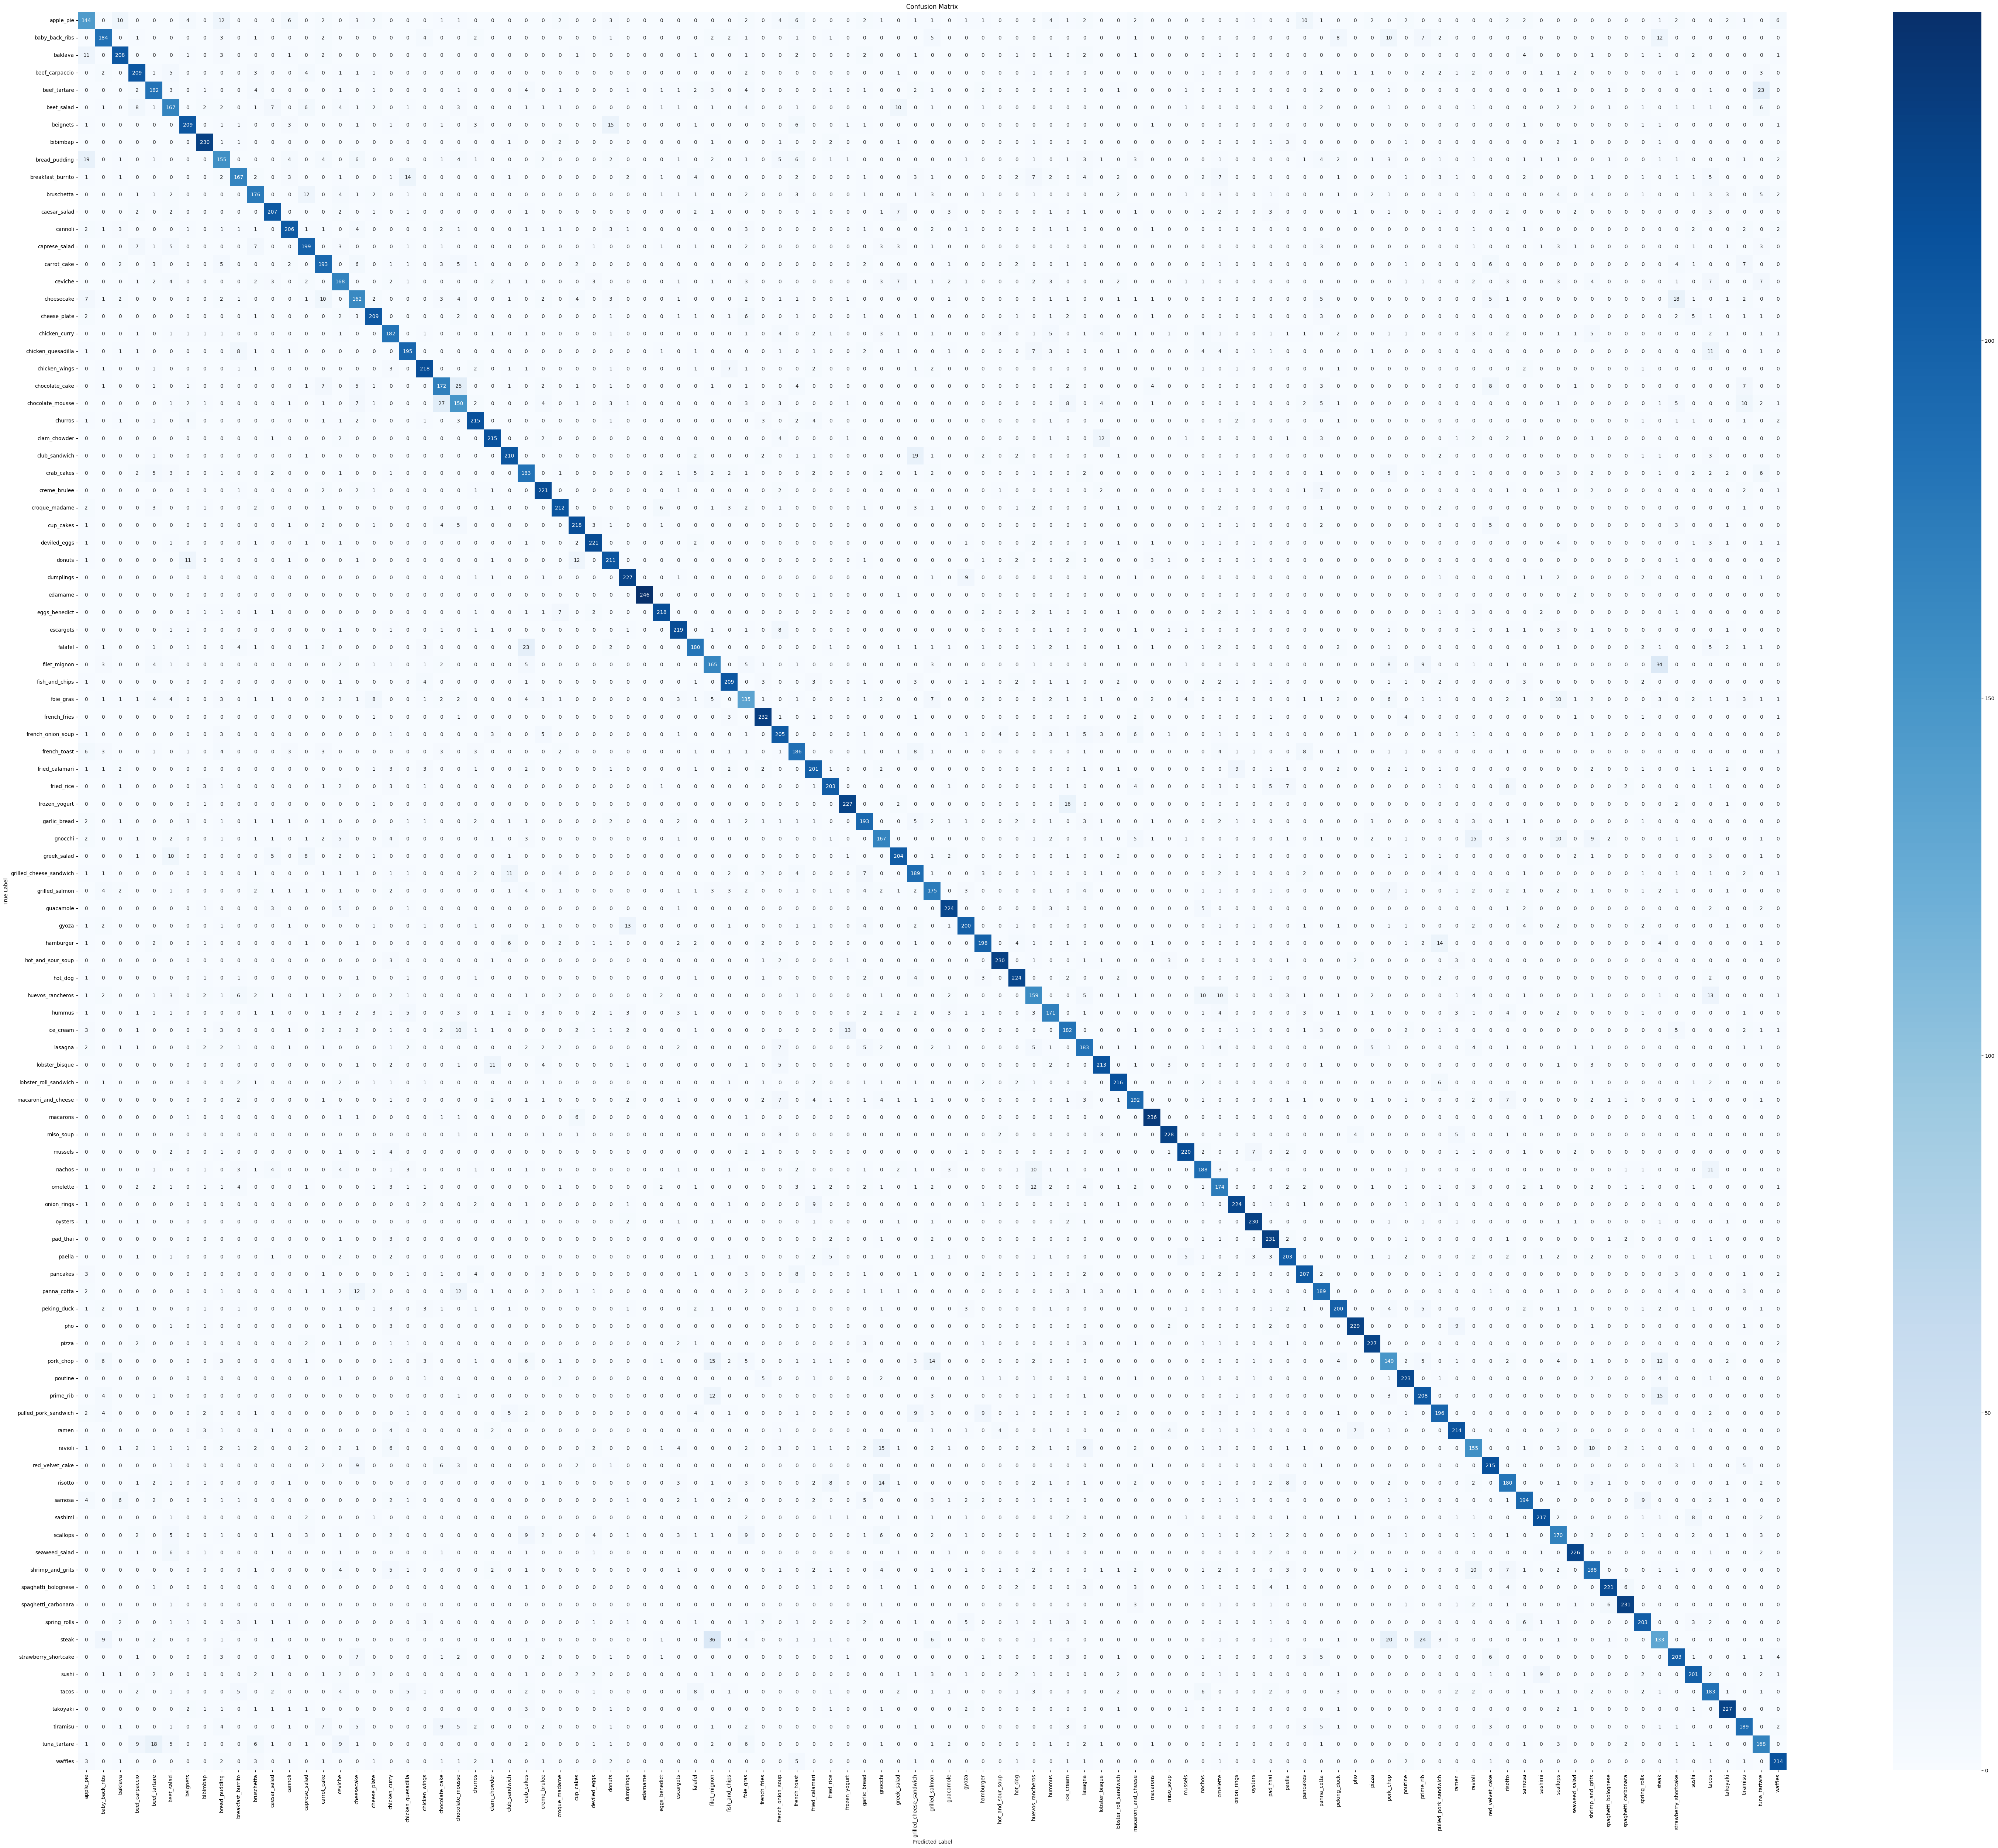

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_true=labels, y_pred=pred_classes)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the Confusion Matrix Using SeaBorn
plt.figure(figsize=(60,50))
plt.title('Confusion Matrix')
sns.heatmap(cm_df,annot=True,fmt='d',cmap='Blues')
plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

### Classification report

In [ ]:
# Get Classification Report
from sklearn.metrics import classification_report
print(classification_report(labels, pred_classes))

              precision    recall  f1-score   support

           0       0.61      0.58      0.59       250
           1       0.78      0.74      0.76       250
           2       0.84      0.83      0.83       250
           3       0.79      0.84      0.81       250
           4       0.73      0.73      0.73       250
           5       0.68      0.67      0.67       250
           6       0.85      0.84      0.84       250
           7       0.88      0.92      0.90       250
           8       0.67      0.62      0.64       250
           9       0.78      0.67      0.72       250
          10       0.76      0.70      0.73       250
          11       0.83      0.83      0.83       250
          12       0.85      0.82      0.84       250
          13       0.78      0.80      0.79       250
          14       0.75      0.77      0.76       250
          15       0.64      0.67      0.66       250
          16       0.65      0.65      0.65       250
          17       0.83    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(labels, pred_classes, output_dict=True)

{'0': {'precision': 0.6050420168067226,
  'recall': 0.576,
  'f1-score': 0.5901639344262294,
  'support': 250},
 '1': {'precision': 0.7796610169491526,
  'recall': 0.736,
  'f1-score': 0.7572016460905351,
  'support': 250},
 '2': {'precision': 0.8353413654618473,
  'recall': 0.832,
  'f1-score': 0.8336673346693386,
  'support': 250},
 '3': {'precision': 0.7857142857142857,
  'recall': 0.836,
  'f1-score': 0.810077519379845,
  'support': 250},
 '4': {'precision': 0.728, 'recall': 0.728, 'f1-score': 0.728, 'support': 250},
 '5': {'precision': 0.6788617886178862,
  'recall': 0.668,
  'f1-score': 0.6733870967741936,
  'support': 250},
 '6': {'precision': 0.8530612244897959,
  'recall': 0.836,
  'f1-score': 0.8444444444444446,
  'support': 250},
 '7': {'precision': 0.8846153846153846,
  'recall': 0.92,
  'f1-score': 0.9019607843137256,
  'support': 250},
 '8': {'precision': 0.6681034482758621,
  'recall': 0.62,
  'f1-score': 0.6431535269709543,
  'support': 250},
 '9': {'precision': 0.77674

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.5901639344262294,
 'baby_back_ribs': 0.7572016460905351,
 'baklava': 0.8336673346693386,
 'beef_carpaccio': 0.810077519379845,
 'beef_tartare': 0.728,
 'beet_salad': 0.6733870967741936,
 'beignets': 0.8444444444444446,
 'bibimbap': 0.9019607843137256,
 'bread_pudding': 0.6431535269709543,
 'breakfast_burrito': 0.7182795698924732,
 'bruschetta': 0.7287784679089028,
 'caesar_salad': 0.828,
 'cannoli': 0.8356997971602435,
 'caprese_salad': 0.788118811881188,
 'carrot_cake': 0.7583497053045187,
 'ceviche': 0.6575342465753425,
 'cheesecake': 0.648,
 'cheese_plate': 0.8343313373253493,
 'chicken_curry': 0.7151277013752456,
 'chicken_quesadilla': 0.7942973523421588,
 'chicken_wings': 0.8650793650793651,
 'chocolate_cake': 0.6935483870967742,
 'chocolate_mousse': 0.6036217303822937,
 'churros': 0.8531746031746033,
 'clam_chowder': 0.8599999999999999,
 'club_sandwich': 0.8502024291497975,
 'crab_cakes': 0.6984732824427481,
 'creme_brulee': 0.8483685220729367,
 'croque_madame': 0

### Visualize F1 Scores

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
33,edamame,0.991935
63,macarons,0.930966
91,spaghetti_carbonara,0.927711
54,hot_and_sour_soup,0.927419
64,miso_soup,0.921212


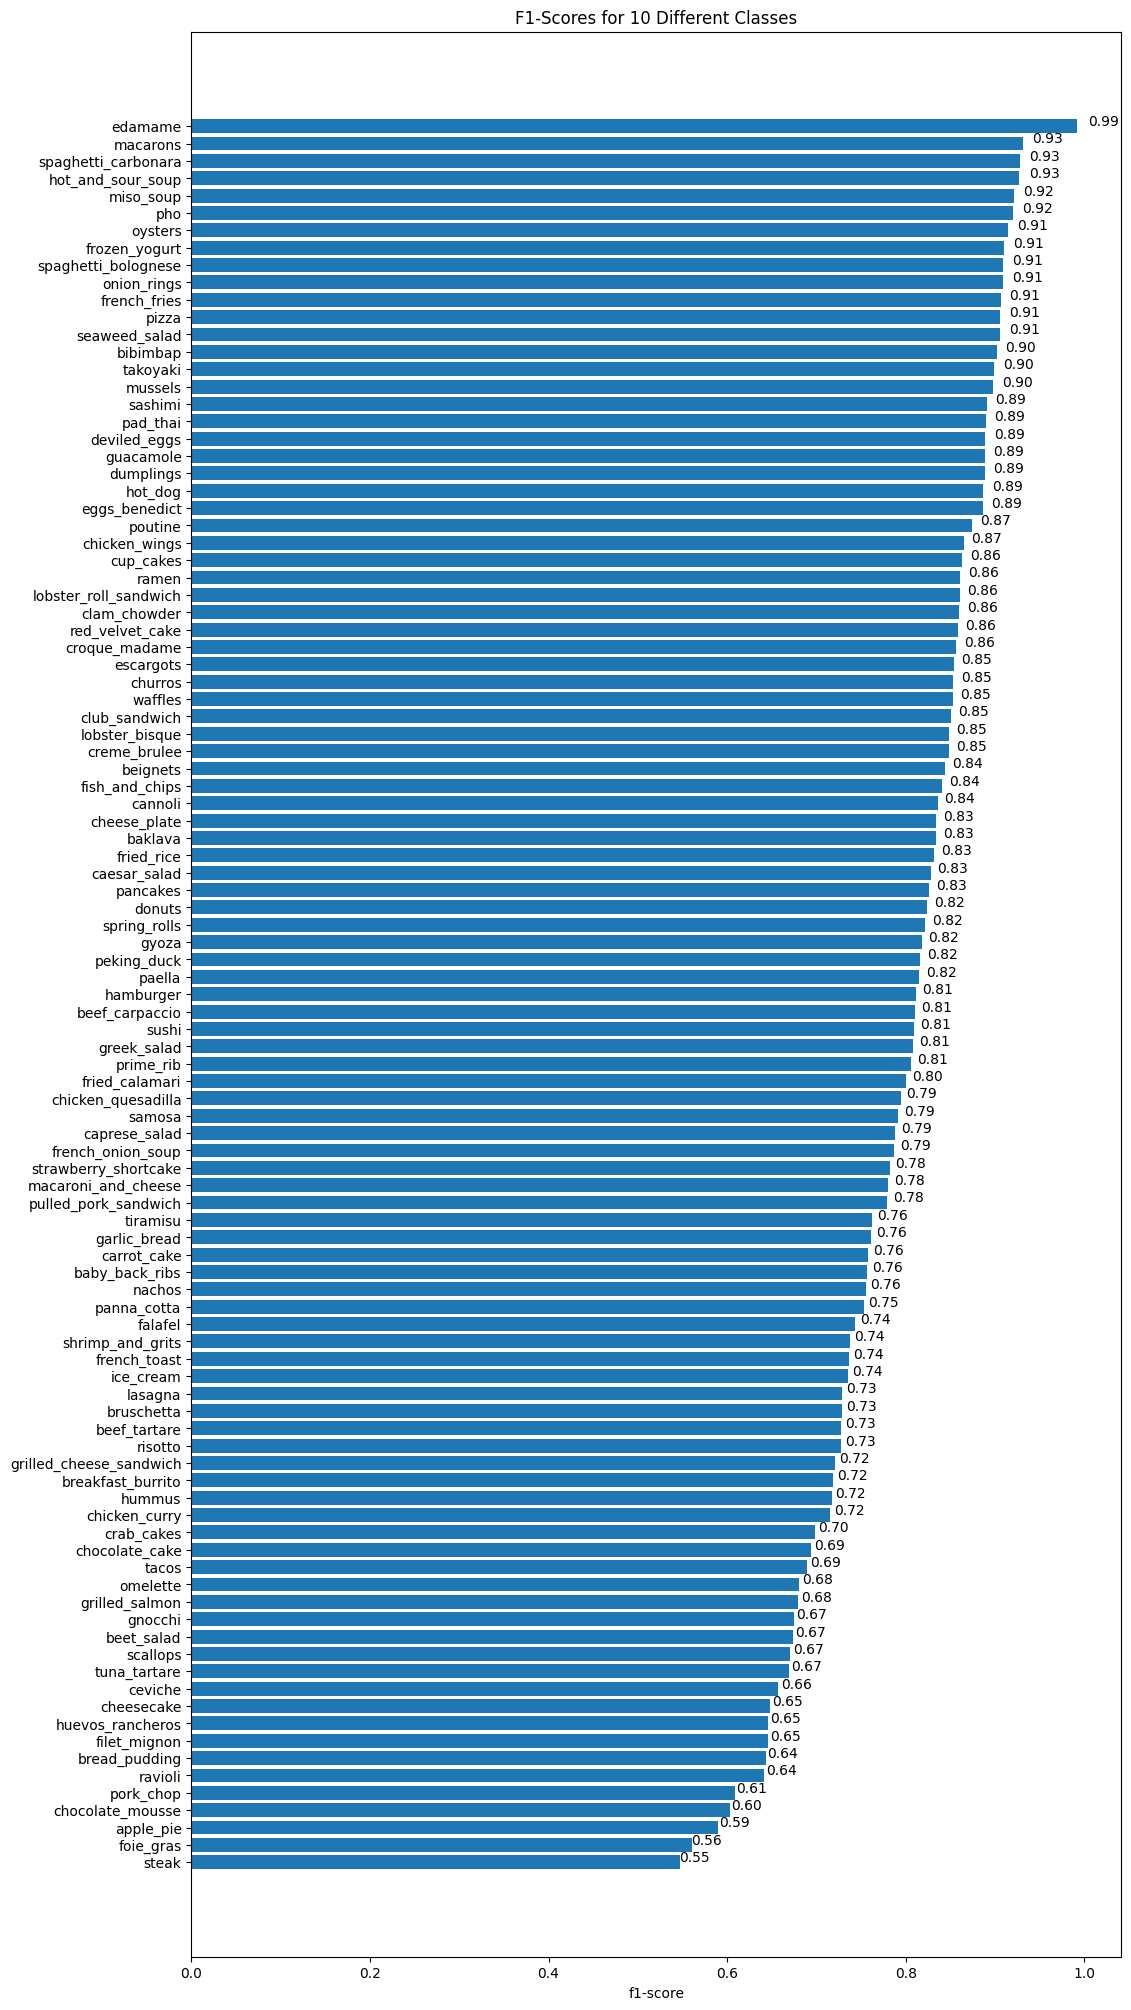

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({
                        "y_true": labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,29,29,0.951964,cup_cakes,cup_cakes
1,81,81,0.990573,ramen,ramen
2,91,91,0.999233,spaghetti_carbonara,spaghetti_carbonara
3,53,53,0.994455,hamburger,hamburger
4,97,97,0.998631,takoyaki,takoyaki


In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,29,29,0.951964,cup_cakes,cup_cakes,True
1,81,81,0.990573,ramen,ramen,True
2,91,91,0.999233,spaghetti_carbonara,spaghetti_carbonara,True
3,53,53,0.994455,hamburger,hamburger,True
4,97,97,0.998631,takoyaki,takoyaki,True


In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
13884,46,10,0.999996,garlic_bread,bruschetta,False
15437,56,66,0.999990,huevos_rancheros,nachos,False
9735,87,30,0.999983,scallops,deviled_eggs,False
217,44,71,0.999975,fried_rice,paella,False
2379,31,6,0.999927,donuts,beignets,False
7455,43,68,0.999860,fried_calamari,onion_rings,False
22358,34,86,0.999846,eggs_benedict,sashimi,False
21838,8,41,0.999804,bread_pudding,french_onion_soup,False
15071,85,92,0.999726,samosa,spring_rolls,False
22219,88,51,0.999666,seaweed_salad,guacamole,False


In [ ]:
import matplotlib.pyplot as plt
def display_random_sample_images(model, test_dataset, class_labels, n):
    """
    Display random sample images from a TensorFlow dataset along with predicted labels.

    Args:
        model: The trained TensorFlow model for prediction.
        test_dataset: The TensorFlow dataset containing test images and labels.
        class_labels: List of class labels for your dataset.
        n: Number of random sample images to display.

    Returns:
        None
    """
    for _ in range(n):
        # Shuffle the dataset and get a random image and label
        test_dataset = test_dataset.shuffle(buffer_size=1000)  # Adjust buffer size as needed
        for image, label in test_dataset.take(1):
            image = image.numpy()
            label = label.numpy()

        # Preprocess the image to match the expected input shape of your model
        image = tf.image.resize(image, (224, 224))  # Adjust the dimensions as needed
        image_dim = tf.expand_dims(image, axis=0)  # Add an extra dimension for the batch size

        # Make a prediction
        prediction = model.predict(image_dim)

        # Get the predicted class (assuming it's a classification problem)
        predicted_class = np.argmax(prediction)

        # Get the true class
        true_class = label

        # Check if the prediction is correct
        is_correct = int(predicted_class) == int(true_class)

        # Scale the image
        image = image/255.
        # Plot the image
        plt.imshow(image)
        plt.axis('off')

        # Display the predicted label in green or red based on correctness
        if is_correct:
            plt.title(f"Predicted: {class_labels[predicted_class]}", color='green')
        else:
            plt.title(f"Predicted: {class_labels[predicted_class]}", color='red')

        # Show the image with the title
        plt.show()


In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Load in the data
(train_data, test_data_img), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata

1/1 [==============================] - 0s 29ms/step


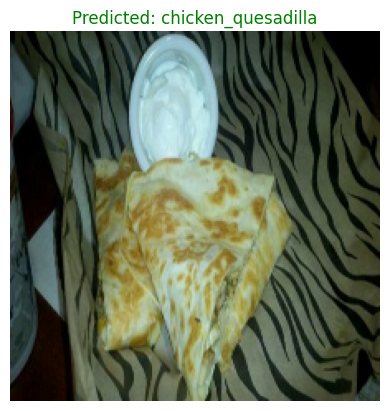

1/1 [==============================] - 0s 45ms/step


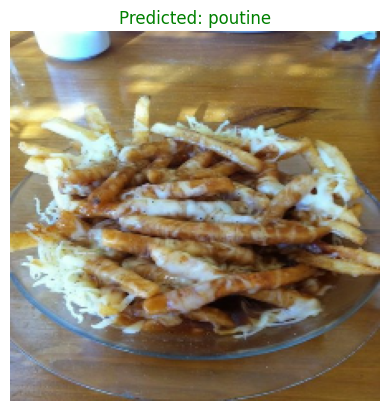

1/1 [==============================] - 0s 27ms/step


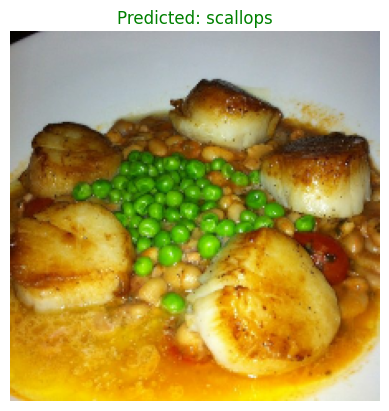

In [ ]:
display_random_sample_images(model, test_data_img, class_names, 3)

## Setup Data Augmentation

In [2]:
import tensorflow as tf

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
# Load in the data
with tf.device('/cpu:0'):
  (train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata

In [3]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224, scale=False):
    """
    Converts image datatype from 'uint8' -> 'float32', reshapes image to
    [img_shape, img_shape, color_channels], and normalize it (optional)
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    if scale:
      image = image/255.
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [4]:
# Get class names
class_names = ds_info.features["label"].names

In [5]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=100).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [6]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

## Building Feature extraction model with augmented layer

In [7]:
# Build data augumentation layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

In [24]:
from keras.src.layers import GlobalAveragePooling2D
# Create base model with data augmentation layer
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)  #pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [25]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [8]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 4 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=4)

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "efficientnetb0_feature_extract_augmented/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_feature_extract = model.fit(train_data,
                                    epochs=3,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs",
                                                                          "efficientnetb0_feature_extract_augmented"),
                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_feature_extract_augmented/20231109-003743
Epoch 1/3
2368/2368 [==============================] - 590s 241ms/step - loss: 2.0820 - accuracy: 0.4976 - val_loss: 1.2872 - val_accuracy: 0.6536
Epoch 2/3
2368/2368 [==============================] - 366s 153ms/step - loss: 1.5984 - accuracy: 0.5937 - val_loss: 1.1772 - val_accuracy: 0.6766
Epoch 3/3
2368/2368 [==============================] - 303s 127ms/step - loss: 1.4684 - accuracy: 0.6218 - val_loss: 1.1495 - val_accuracy: 0.6899


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 54s 67ms/step - loss: 1.1662 - accuracy: 0.6847


[1.166192889213562, 0.6846732497215271]

## Load trained feature extraction model with augmented layer

In [9]:
# 1. Create a function to recreate the original model
from keras.src.layers import GlobalAveragePooling2D
def create_aug_model():
   # Create base model with data augmentation layer
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False

  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = data_augmentation(inputs)
  x = base_model(x, training=False)  #pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
  x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  x = layers.Dense(len(class_names))(x)
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model_aug = tf.keras.Model(inputs, outputs)

  return model_aug

# 2. Create and compile a new version of the original model (new weights)
fine_tune_aug_model = create_aug_model()
fine_tune_aug_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
fine_tune_aug_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
#results_created_model_with_loaded_weights = fine_tune_aug_model.evaluate(test_data)

In [10]:
# Set all layers to trainable
for layer in fine_tune_aug_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Building fine tuned model with data augmentation

In [11]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 4 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_aug_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [12]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.1, # multiply the learning rate by 0.1 (reduce by 10x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [13]:
# Compile the model
fine_tune_aug_model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [18]:
# Start to fine-tune (all layers)
history_fine_tune_aug = fine_tune_aug_model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_fine_tuning_aug"), # track the model training logs
                                      model_checkpoint, # save only the best model during training
                                      early_stopping, # stop model after X epochs if no improvements
                                      reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_fine_tuning_aug/20231109-164615
Epoch 1/100
2368/2368 [==============================] - 2234s 922ms/step - loss: 1.1760 - accuracy: 0.6915 - val_loss: 0.9451 - val_accuracy: 0.7397 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 1038s 438ms/step - loss: 0.9195 - accuracy: 0.7512 - val_loss: 0.9428 - val_accuracy: 0.7357 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.7858
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2368/2368 [==============================] - 669s 282ms/step - loss: 0.7696 - accuracy: 0.7858 - val_loss: 0.9684 - val_accuracy: 0.7352 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 603s 254ms/step - loss: 0.5292 - accuracy: 0.8526 - val_loss: 0.8164 - val_accuracy: 0.7752 - lr: 1.0000e-05
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4838 

In [1]:
history_list = [history_fine_tune_aug] # Fix name history_feature_extract_aug
metrics = ["accuracy"]


plot_loss_curves(history_list, finetune=True)

NameError: ignored

In [1]:
# # Save model to Google Drive
fine_tune_aug_model.save("/content/drive/MyDrive/FoodVisionFineTuneAug/")

NameError: ignored

In [20]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
fine_tune_aug_model.save("efficientnetb0_fine_tuned_aug")

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
#saved_model_path = "efficientnetb0_fine_tuned.zip"
#unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
model = tf.keras.models.load_model("/content/drive/MyDrive/FoodVisionFineTuneAug/") # path to drive model